In [36]:
%%html
<text style='width: 500%; color: red;'><b>NOTE: If you run this notebok the graphs will update and the performance of the models will be slightly different</b></text>

In [1]:
student_id = 'Student-ID'
data_zip_name = 'DS-20200801T075344Z-001.zip'

# Load and preprocess data

In [2]:
from pathlib import Path
# Extract the dataset into the current directory
if not Path("DS/Abdomen_CT Sample#0.jpeg").is_file():
    import zipfile  
    with zipfile.ZipFile(data_zip_name, 'r') as archive:
        archive.extractall()

In [3]:
from torch.utils.data import Dataset
import torch
from PIL import Image
from torchvision import transforms

class CTDataset(Dataset):
    
    def __init__(self, data_path):
        self.data_path = data_path # path to the dataset
        self.file_paths, self.labels = self.read_data() # load image paths and image labels
        self.len_dataset = len(self.labels)
        size = 32
        # this transformation is for resizing each image to 32x32 and converting it to tensor
        self.transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])

    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, idx):
        # loading image, transforming it, assigning numbered labels
        return self.transform(self.pil_loader(self.file_paths[idx])), torch.tensor(self.labels[idx])

    def pil_loader(self, path):
      # open path as file to avoid ResourceWarning
      with open(path, 'rb') as f:
          img = Image.open(f) # loading image
          return img.convert('L') # transforming to gray mode

    def read_data(self):
      file_paths, labels = [], []
      classname_to_label = {'Abdomen' : 0, 'Chest' : 1, 'Head' : 2}
      for file_path in self.data_path.iterdir():
          file_paths.append(file_path) # composinglist of paths to images
          class_name = file_path.name.split('_')[0] # class name is written in the first part of a file name
          labels.append(int(classname_to_label[class_name])) # convert  class name to number according to dictionary
      return file_paths, labels


In [4]:
from torch.utils.data import random_split
data_path = Path('DS')
dataset = CTDataset(data_path) # initialize the dataset
# spliting dataset in parts: train - 66%, val - 14% and test - 20%
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=(1000, 200, 300))

## Looking at image samples

0 Chest
1 Abdomen
2 Abdomen
3 Chest
4 Head
5 Chest
6 Chest
7 Abdomen
8 Abdomen
9 Head


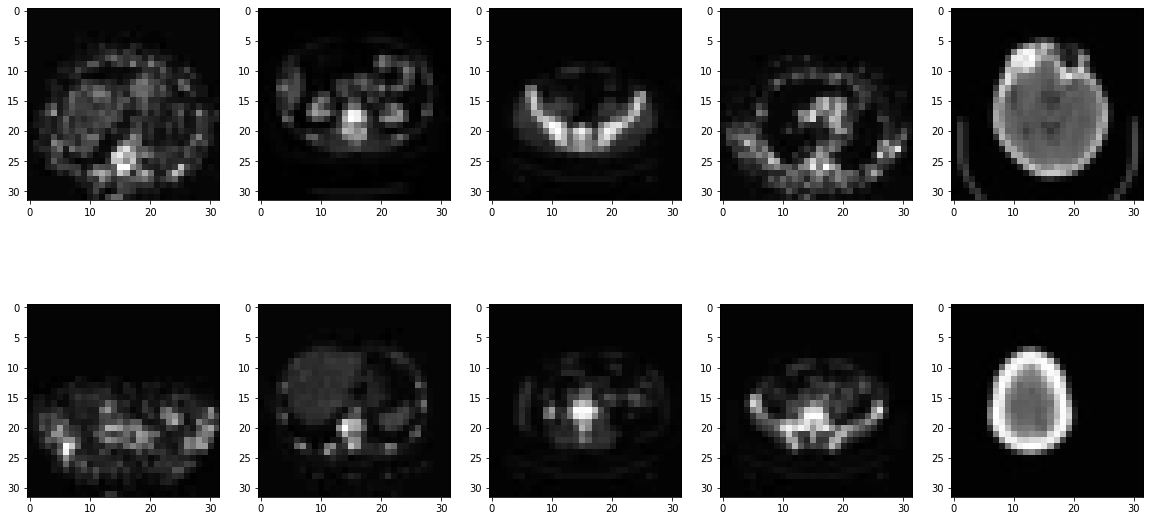

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False) # iterator over the train dataset

label_to_classname = {0 : 'Abdomen', 1: 'Chest', 2: 'Head'}
fig,ax = plt.subplots(2, 5, figsize=(20, 10))
for i, (image, label) in enumerate(train_loader):
  if i >= 10:
    break
  print (i, label_to_classname[label.item()])
  ax[int(i/5), i%5].imshow(np.asarray(image[0, 0, :]), cmap='gray')

# Extract features with Convolutional network

## Defining CNN

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3) # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 3) # 6 input channel, 16 output channels, 3x3 square convolution kernel
        # fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 16)
        self.fc3 = nn.Linear(16, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # transform 2d array to 1d
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training CNN

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from time import time
from sklearn.metrics import roc_auc_score

class TrainingModule:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, epochs, checkpoint = True, early_stop = False):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.checkpoint = checkpoint
        self.early_stop = early_stop
        
    def train(self):
        list_train_loss = []
        list_val_loss = []
        
        best_val_loss = float('+inf')
        
        for epoch in range(self.epochs):
          
            start_time = time()

            train_loss = self.run_epoch(dataloader = self.train_loader, mode='train')
            val_loss = self.run_epoch(dataloader = self.val_loader, mode='val')

            list_train_loss.append(train_loss)
            list_val_loss.append(val_loss)

            # checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                
                if self.checkpoint:
                    torch.save(self.model.state_dict(), './best_model.pth')

            if (epoch+1) % 1 == 0:
              print('Epoch {}: train loss - {}'.format(epoch+1, round(train_loss,5)))
              print('Epoch {}: val loss - {}'.format(epoch+1, round(val_loss,5)))
              print ('Elapsed time: %.3f' % (time() - start_time))
              print('----------------------------------------------------------------------')
            
        return list_train_loss, list_val_loss


    def run_epoch(self, mode, dataloader):
      
        if mode == 'train':
            self.model.train()
        else:
            self.model.eval()

        epoch_loss = 0.0
        
        num_batches = 0
        for vector, target in dataloader:
          
            prediction = self.model(vector)
            loss = self.criterion(prediction, target)
            
            if mode == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1
            
            if self.early_stop:
                break
        
        num_batches = float(num_batches)

        return epoch_loss/num_batches

In [8]:
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import random 

batch_size = 64
lr = 1e-3
wd = 1e-6

SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
model = Net()

########################################################################################
N_EPOCHS = 3
LR = lr

optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=wd)
criterion = nn.CrossEntropyLoss()

train_class = TrainingModule(model, optimizer, criterion, train_loader, val_loader, N_EPOCHS, early_stop=False)
list_train_loss, list_val_loss = train_class.train()

Epoch 1: train loss - 1.11306
Epoch 1: val loss - 1.10961
Elapsed time: 0.728
----------------------------------------------------------------------
Epoch 2: train loss - 1.11155
Epoch 2: val loss - 1.10924
Elapsed time: 0.671
----------------------------------------------------------------------
Epoch 3: train loss - 1.11098
Epoch 3: val loss - 1.10888
Elapsed time: 0.671
----------------------------------------------------------------------


## Defining feature extractor

In [9]:
# Nework layer that does nothing
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [10]:
def create_feature_extractor():
  model = Net() #define the cnn model
  model.load_state_dict(torch.load('best_model.pth'))
  model.eval() # put it in evaluation mode, it won't compute gradients and update the parameters anymore
  feature_extractor = model
  feature_extractor.fc3 = Identity() # remove the last layer of the network
  return lambda image: feature_extractor(image).detach() # define extraction function that transforms image into a feature vector

### This is how feature extractor works

In [11]:
feature_extractor = create_feature_extractor()

In [12]:
image = train_dataset[0][0][None, :] # choosing an image to extract features from

### This is how our image looks like

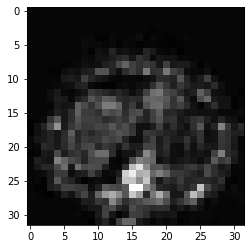

In [13]:
fig,ax = plt.subplots(1, figsize=(5, 4))
ax.imshow(np.asarray(image[0, 0, :, :]), cmap='gray')
plt.show()

### And this is a feature vector extracted from it

In [14]:
feature_vector = feature_extractor(image)
print ('Size of the feature vector: ', feature_vector.size(1))
print ()
print ('Values of the vector: ')
print ()
print (feature_vector)

Size of the feature vector:  16

Values of the vector: 

tensor([[0.0000, 0.0000, 0.0445, 0.0140, 0.0399, 0.0000, 0.0000, 0.0004, 0.0000,
         0.0747, 0.0810, 0.0000, 0.1344, 0.1177, 0.0537, 0.0080]])


# Apply k nearest neighbors and find the optimal value of k

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

# function to extract features
feature_extractor = create_feature_extractor()
# transformer of class number to one-hot vector (e.g. 0 => [1 0 0], 2 => [0 0 1])
enc = OneHotEncoder(handle_unknown='ignore')
k_values = [3, 5, 7, 9]
train_scores = np.zeros(len(k_values)) # array to hold performance scores on train dataset
val_scores = np.zeros(len(k_values)) # array to hold performance scores on test dataset

for i, k in enumerate(k_values): #i - loop counter, k - number of neighbors

  # instance of KNN classifier
  neigh = KNeighborsClassifier(n_neighbors=k)

  # loader that holds every example from the train dataset
  train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
  for image_train, y_train in train_loader: # this loop only happens ones as our batch is the whole train dataset
    X_train = feature_extractor(image_train) # convert each image to corresponding feature vector
    neigh.fit(X_train, y_train) # fit the KNN classifier on feature vectors and labels of train images
    prediction = neigh.predict(X_train) # predict labels for feature vectors of train images
    prediction = prediction.reshape(-1, 1)  # array([1, 2, 1, 0, ...]) => array([[1], [2], [1], [0], ...])
    train_scores[i] = f1_score(prediction, y_train, average='micro') # calculate f1 score on train predictions

  # loader that holds every example from the test dataset
  val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
  for image_val, y_val in val_loader: # this loop only happens ones as our batch is the whole val dataset
    X_val = feature_extractor(image_val) # convert each image to corresponding feature vector
    prediction = neigh.predict(X_val) # predict labels for feature vectors of val images
    prediction = prediction.reshape(-1, 1)  # array([1, 2, 1, 0, ...]) => array([[1], [2], [1], [0], ...])
    val_scores[i] = f1_score(prediction, y_val, average='micro') # calculate f1 score on test predictions

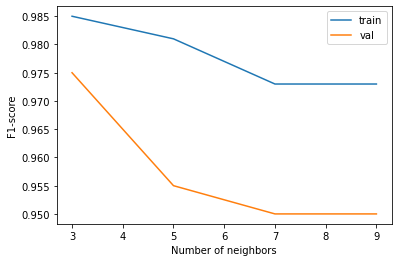

In [16]:
plt.plot(k_values, train_scores, label='train')
plt.plot(k_values, val_scores, label='val')
plt.xlabel('Number of neighbors')
plt.ylabel('F1-score')
plt.savefig(student_id+'-KNN.jpg')
plt.legend()
plt.show()

According to the graph, KNN with 3 neighbors gives the best performance

## Saving the best model

In [17]:
import pickle
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
filename = student_id+'-KNN.pkl'
pickle.dump(neigh, open(filename, 'wb'))

## Testing the best model

In [18]:
neigh = pickle.load(open(filename, 'rb'))

In [19]:
# loader that holds every example from the test dataset
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
for image_test, y_test in test_loader: # this loop only happens ones as our batch is the whole test dataset
  X_test = feature_extractor(image_test) # convert each image to corresponding feature vector
  prediction = neigh.predict(X_test) # predict labels for feature vectors of test images
  prediction = prediction.reshape(-1, 1)  # array([1, 2, 1, 0, ...]) => array([[1], [2], [1], [0], ...])
  print ('F1 score: ', f1_score(prediction, y_test, average='micro')) # calculate f1 score on test predictions

F1 score:  0.9733333333333334


## Looking at incorrectly classified images

correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest
correct label: Head; prediction: Abdomen
correct label: Head; prediction: Abdomen
correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest


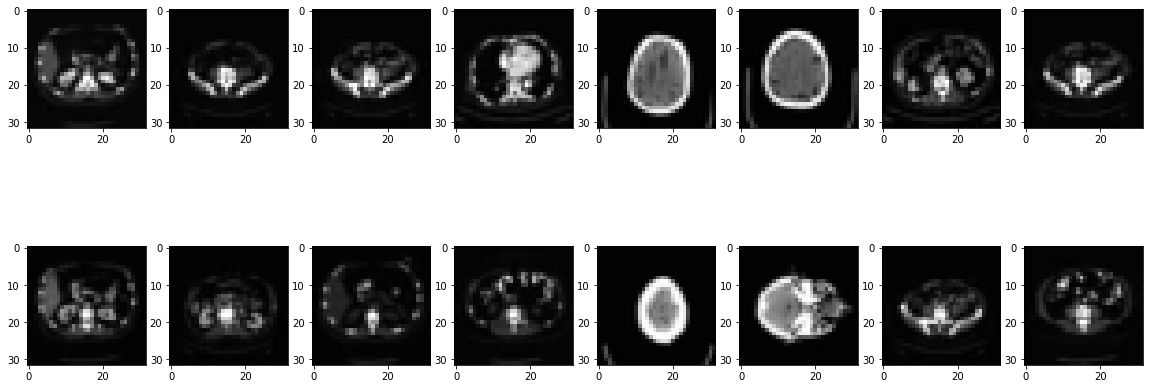

In [20]:
pred = torch.from_numpy(prediction.reshape(-1, )) # numpy array predictions
mistaken_images = image_test[pred != y_test] # images that were incorrectly classified
labels = y_test[pred != y_test] # correct labeles of this images
preds = pred[pred != y_test] # predicted labels of this images

 # we will display each incorrectly classified image and correctly classified image of the same class underneath it
fig, ax = plt.subplots(2, len(mistaken_images), figsize=(20, 8))
for i, image in enumerate(mistaken_images):
  #show incorrectly classified image
  ax[0, i].imshow(image[0, :], cmap='gray')
  # real label of this image
  label = labels[i].item()
  # printing correct and predicted labels
  print ('correct label:', label_to_classname[label]+';', 'prediction:', label_to_classname[preds[i].item()])
  # images that were correctly classified
  correct_images = image_test[[pred == y_test]]
  # and their labels
  correct_labels = y_test[pred == y_test]
  # choose a random correctly classified image of the same label as incorrect one
  correct_image = random.choice(correct_images[correct_labels==label])
  #show correctly classified image
  ax[1, i].imshow(correct_image[0, :], cmap='gray')
plt.show()

# Apply Random Forest and find optimal hyperparameter values

In [21]:
#number_of_parameter_values = 10 # (10**2)=100 configurations, 3*100=300 fits in 10 min
number_of_parameter_values = 5 # (5**2)=25 configurations, 3*25=75 fits in 2.5 min

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = number_of_parameter_values)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = number_of_parameter_values)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
n_iter = number_of_parameter_values**2
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = 'f1_micro', n_iter = n_iter, cv = 3, verbose=2, random_state=42, n_jobs = -1)

feature_extractor = create_feature_extractor()

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
for image_train, y_train in train_loader: # this loop only happens ones as our batch is the whole train dataset
  X_train = feature_extractor(image_train) # convert each image to corresponding feature vector
  # Fit the random search model
  rf_random.fit(X_train, y_train) # fit the RF random search classifier on feature vectors and labels of train images
  prediction = rf_random.predict(X_train) # make a prediction
  prediction = prediction.reshape(-1, 1)
  f1 = f1_score(prediction, y_train, average='micro') # calculate f1 score on train predictions
  print ('Train f1 score: ', f1)
  print ()
  print ('Best params: ', rf_random.best_params_) # show best params found by random search

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.7s finished


Train f1 score:  1.0

Best params:  {'n_estimators': 75, 'max_depth': 100}


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


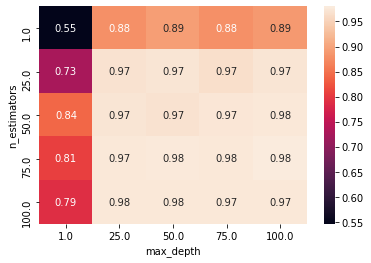

In [23]:
import seaborn as sns       
import pandas as pd
df = pd.DataFrame(rf_random.cv_results_['params']) # creating a dataframe of all considered parameter values
result = np.concatenate([df.values, rf_random.cv_results_['mean_test_score'].reshape(-1, 1)], axis=1) # add scores of each parametes combination
df = pd.DataFrame(result, columns=['n_estimators', 'max_depth', 'score']) # put it inside a dataframe
df = df.pivot("n_estimators", "max_depth", "score") # preprocess for plotting the heatmap
ax = sns.heatmap(df, annot=True) # plot the heatmap of scores
plt.savefig(student_id+'-RF.jpg') # save the figure
plt.show()

Best values of RF hyperparameters max_depth and n_estimators are 100 and 75 according to f1 score performance metrics

## Saving the model

In [24]:
filename = student_id+'-RF.pkl'
pickle.dump(rf_random, open(filename, 'wb'))

# Testing the best model

In [25]:
rf_random = pickle.load(open(filename, 'rb'))

Test f1 score:  0.9633333333333334


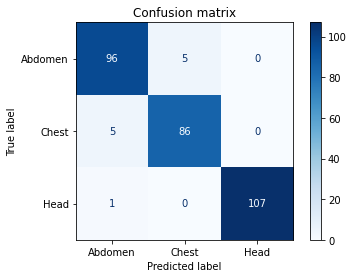

In [26]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
for image_test, y_test in test_loader: # this loop only happens ones as our batch is the whole test dataset
  X_test = feature_extractor(image_test) # convert each image to corresponding feature vector
  prediction = rf_random.predict(X_test) # make a prediction
  prediction = prediction.reshape(-1, 1)
  f1 = f1_score(prediction, y_test, average='micro') # calculate f1 score on test predictions

  print ('Test f1 score: ', f1)

  # plot confusion matrix of the result
  disp = plot_confusion_matrix(rf_random, X_test, y_test,
                                 display_labels=['Abdomen', 'Chest', 'Head'],
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                 values_format='d')
  disp.ax_.set_title('Confusion matrix')
plt.show()

## Looking at incorrectly classified images

correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest
correct label: Chest; prediction: Abdomen
correct label: Chest; prediction: Abdomen
correct label: Abdomen; prediction: Chest
correct label: Abdomen; prediction: Chest
correct label: Head; prediction: Abdomen
correct label: Chest; prediction: Abdomen
correct label: Chest; prediction: Abdomen
correct label: Chest; prediction: Abdomen
correct label: Abdomen; prediction: Chest


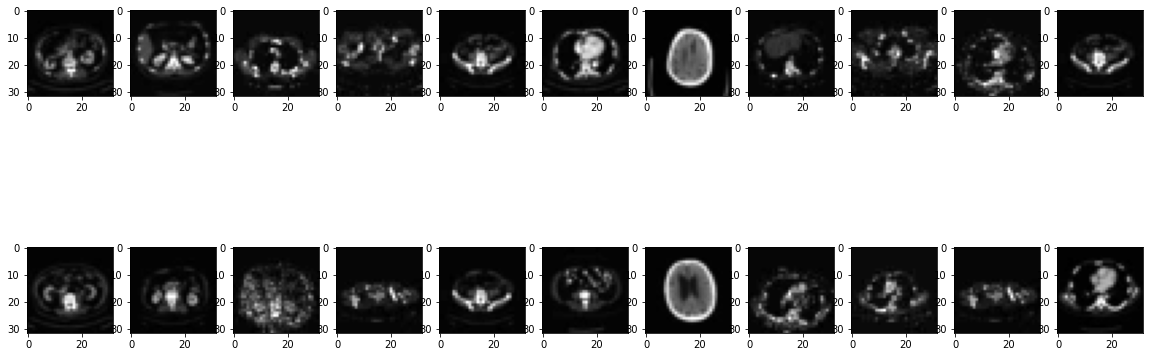

In [27]:
pred = torch.from_numpy(prediction.reshape(-1, )) # numpy array predictions
mistaken_images = image_test[pred != y_test] # images that were incorrectly classified
labels = y_test[pred != y_test] # correct labeles of this images
preds = pred[pred != y_test] # predicted labels of this images

 # we will display each incorrectly classified image and correctly classified image of the same class underneath it
fig, ax = plt.subplots(2, len(mistaken_images), figsize=(20, 8))
for i, image in enumerate(mistaken_images):
  #show incorrectly classified image
  ax[0, i].imshow(image[0, :], cmap='gray')
  # real label of this image
  label = labels[i].item()
  # printing correct and predicted labels
  print ('correct label:', label_to_classname[label]+';', 'prediction:', label_to_classname[preds[i].item()])
  # images that were correctly classified
  correct_images = image_test[[pred == y_test]]
  # and their labels
  correct_labels = y_test[pred == y_test]
  # choose a random correctly classified image of the same label as incorrect one
  correct_image = random.choice(correct_images[correct_labels==label])
  #show correctly classified image
  ax[1, i].imshow(correct_image[0, :], cmap='gray')
plt.show()

# Analyzing results

Both algorithms make prediction mistakes mostly on Abdomen class. Let's look at class distribution

In [28]:
# count how many instances of each class are there (0 - 'Abdomen', 1 - 'Chest', 2 - 'Head')
label_counter = np.zeros(3)
for _, y_train in train_dataset:
  label_counter[y_train.item()] += 1

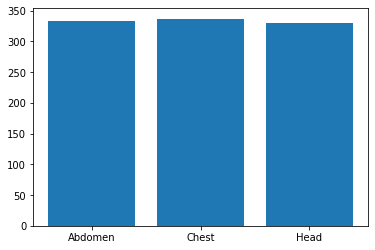

In [29]:
plt.bar(range(0, 3), label_counter, align='center') # plot a distribution of classes
plt.xticks(range(0, 3), ['Abdomen', 'Chest', 'Head']) # display the label of each class
plt.show()

Dataset is unbalanced having less instances of Abdomen class and the most instance of Chest class. This explains why some images of abdomen are mislabeled in favor of Chest class.